In [13]:
import re
import pandas as pd
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt
from collections import Counter
from itertools import tee
import plotly.io as pio
import plotly.graph_objects as go
import seaborn as sns
pio.renderers.default = 'notebook'


In [14]:
path=r'C:\Users\PC\Desktop\Projects\User Journey Analysis in Python Project\cleaned_user_journey.csv'
df = pd.read_csv(path)
df

,user_id,user_journey
0,1516,Homepage-Other-Other-Sign up-Homepage-Checkout...
1,3395,Other-Pricing-Sign up-Homepage-Pricing-Pricing...
2,10107,Homepage-Homepage-Career tracks-Homepage-Caree...
3,11145,Homepage-Homepage-Homepage-Homepage-Homepage-H...
4,12400,Homepage-Career tracks-Sign up-Other-Career tr...
...,...,...
1345,509060,Other-Other
1346,509061,Coupon
1347,509085,Coupon
1348,509095,Other-Other-Other-Other


## Page count function; it counts how many times each page can be found in all user journeys.


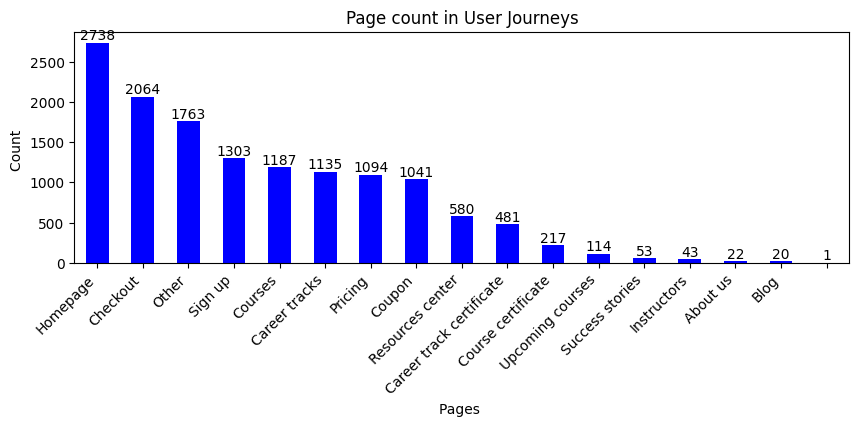

In [15]:
def page_count(df):
    target_column = df['user_journey'].fillna('')
    pages = list(chain.from_iterable(target_column.str.split('-')))
    return pd.Series(pages).value_counts()

page_counts = page_count(df)

plt.figure(figsize=(10,3))
page_counts.plot(kind='bar' , color='blue')
plt.title('Page count in User Journeys')
plt.xlabel('Pages ')
plt.ylabel('Count ')
plt.xticks(rotation=45, ha='right')   

# Add count values above each bar
for i, count in enumerate(page_counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.show()

## Page presence function ;  counts each page only once if it exists in a journey; it shows how many times each page is part of a journey


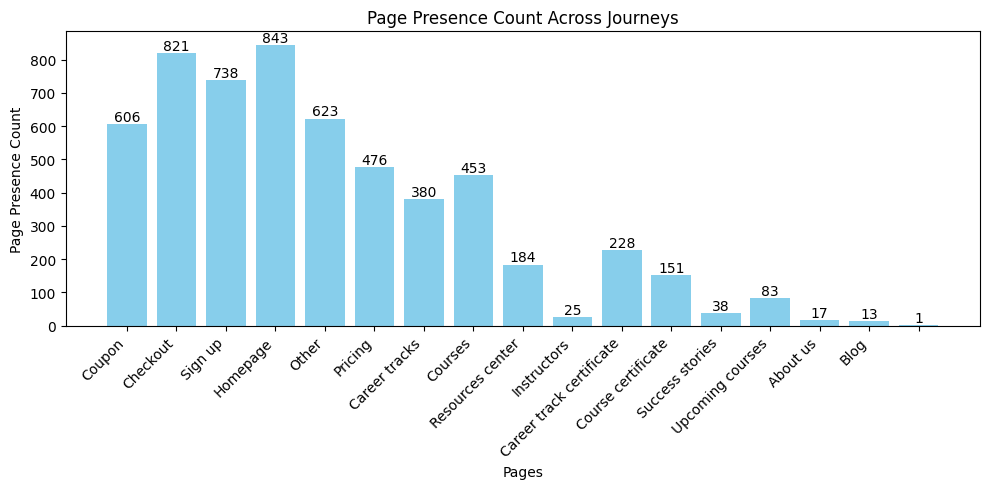

In [17]:

def Page_presence(df):
    target_column = df['user_journey'].fillna('')
    page_counts= Counter()
    for journey in target_column:
        pages_in_journey = set(journey.split('-'))
        page_counts.update(pages_in_journey)
    return page_counts
testing = Page_presence(df)
pages = list(testing.keys())
counts = list(testing.values())


fig = plt.figure(figsize = (10, 5))
plt.bar(pages, counts, color='skyblue')
plt.xlabel('Pages')
plt.ylabel('Page Presence Count')
plt.title('Page Presence Count Across Journeys')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.show()

#testing= Page_presence(df)
#testing

## Page destination , It looks at every page and counts which pages follow next. If one is interested in what the users do after visiting page X, they can consult this metric.


In [25]:
# Step 1: Split each user journey into individual pages
# Step 2: Create transitions (page pairs)
# Step 3: Count occurrences of each transition
# Step 4: Convert transition counts to DataFrame for analysis
# Step 5: Find the most frequent destination for each start_page


df['journey_list'] = df['user_journey'].apply(lambda x: x.split('-') if isinstance(x, str) else [])

transitions = []
for journey in df['journey_list']:
    for i in range(len(journey) - 1):
        transitions.append((journey[i], journey[i + 1]))

transition_counts = Counter(transitions)

# Step 4: Convert transition counts to DataFrame for analysis
transition_df = pd.DataFrame(transition_counts.items(), columns=['transition', 'count'])
transition_df[['start_page', 'next_page']] = pd.DataFrame(transition_df['transition'].tolist(), index=transition_df.index)
transition_df = transition_df.drop(columns='transition')

# Step 5: Find the most frequent destination for each start_page
most_frequent_destinations = transition_df.loc[transition_df.groupby('start_page')['count'].idxmax()].reset_index(drop=True)
most_frequent_destinations = most_frequent_destinations.sort_values(by='count', ascending=False).reset_index(drop=True)

most_frequent_destinations


,count,start_page,next_page
0,808,Checkout,Checkout
1,635,Other,Other
2,536,Homepage,Homepage
3,398,Sign up,Homepage
4,355,Career tracks,Courses
5,352,Resources center,Other
6,334,Coupon,Coupon
7,318,Pricing,Checkout
8,290,Courses,Career tracks
9,173,Career track certificate,Career tracks


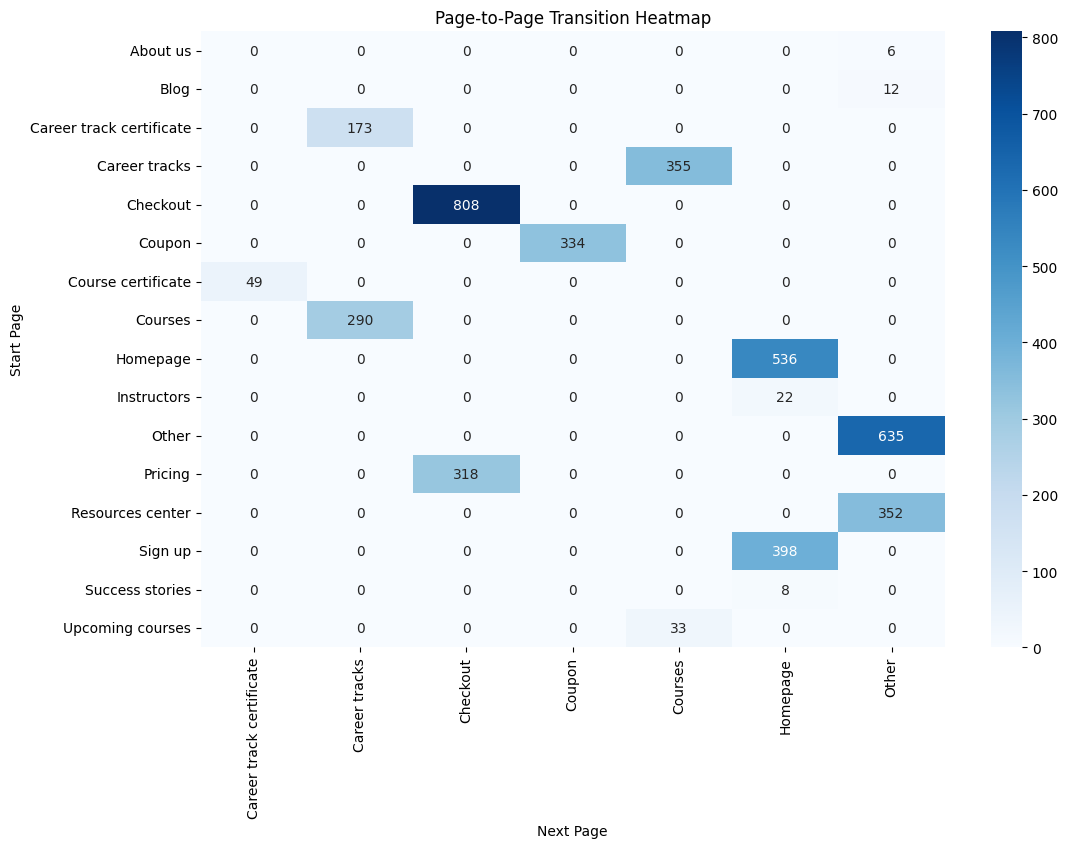

In [27]:

# Create a pivot table for the heatmap
heatmap_data = most_frequent_destinations.pivot(index="start_page", columns="next_page", values="count").fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Blues")
plt.title("Page-to-Page Transition Heatmap")
plt.xlabel("Next Page")
plt.ylabel("Start Page")
plt.show()


## Page sequences look at what the most popular run of N pages is. I will consult this metric if I’m interested in the sequence of three (or any other number) pages that most often shows up. Count each sequence only once per journey.


Sequence: Checkout-Checkout-Checkout-Checkout, Count: 77
Sequence: Other-Other-Other-Other, Count: 68
Sequence: Sign up-Checkout-Checkout-Checkout, Count: 54
Sequence: Homepage-Checkout-Checkout-Checkout, Count: 44
Sequence: Homepage-Career tracks-Homepage-Career tracks, Count: 44
Sequence: Homepage-Pricing-Checkout-Pricing, Count: 44
Sequence: Career tracks-Courses-Career tracks-Courses, Count: 42
Sequence: Courses-Career tracks-Courses-Career tracks, Count: 38
Sequence: Pricing-Checkout-Pricing-Checkout, Count: 37
Sequence: Homepage-Pricing-Homepage-Pricing, Count: 37


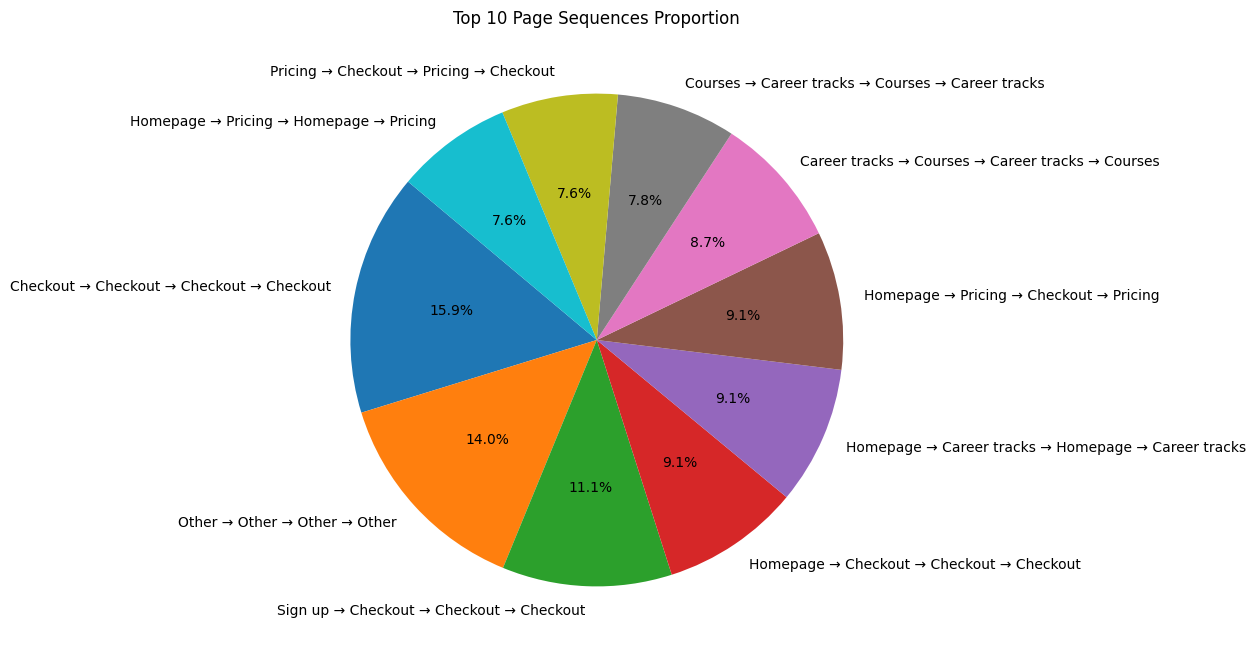

In [54]:
# Step 1: Define the sequence length
# Step 2: Extract and count sequences
# Step 3: Find the most popular sequences
N = 4
df['user_journey'] = df['user_journey'].fillna("").astype(str)

sequence_counts = Counter()
for journey in df['user_journey']:
    pages = journey.split('-')  
    unique_sequences = set(tuple(pages[i:i+N]) for i in range(len(pages) - N + 1))  # Sliding wndow of size N
    sequence_counts.update(unique_sequences)  # Count unique sequences

most_common_sequences = sequence_counts.most_common(10)  # Get the top 10 most common sequences
for sequence, count in most_common_sequences:
    print(f"Sequence: {'-'.join(sequence)}, Count: {count}")

# Extract sequences and counts
sequences = [' → '.join(seq) for seq, count in most_common_sequences]
counts = [count for seq, count in most_common_sequences]

# Viz
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=sequences, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
plt.title('Top 10 Page Sequences Proportion')
plt.show()


## Journey length is a straightforward metric that considers the average length of a user journey in terms of pages.


In [50]:
#Load Data: Read the dataset containing user journeys.
#Handle Missing Values: Replace NaN or invalid entries with an empty journey ("").
#Split and Count: Split each journey into pages and count the number of pages.
#Calculate the Average: Compute the mean of all journey lengths.
# Ensure all entries in 'user_journey' are strings, and handle NaN or invalid values
df['user_journey'] = df['user_journey'].fillna("").astype(str)

# Calculate the length of each journey
df['journey_length'] = df['user_journey'].apply(lambda x: len(x.split('-')) if x.strip() else 0)

# Calculate the average journey length
average_journey_length = df['journey_length'].mean()

# Output the result
print(f"The average user journey length is: {average_journey_length:.2f} pages.")


The average user journey length is: 10.26 pages.


In [53]:
short_journeys = df[df['journey_length'] <= 5]
long_journeys = df[df['journey_length'] > 10]

short_journey_metrics = page_count(short_journeys)
long_journey_metrics = page_count(long_journeys)

# Compare metrics side by side
comparison = pd.DataFrame({
    "Short Journeys": short_journey_metrics,
    "Long Journeys": long_journey_metrics
}).fillna(0)
print(comparison)


                          Short Journeys  Long Journeys
                                     1.0            0.0
About us                             0.0           19.0
Blog                                 1.0           15.0
Career track certificate            14.0          408.0
Career tracks                       38.0          979.0
Checkout                           347.0         1280.0
Coupon                             421.0          442.0
Course certificate                   5.0          173.0
Courses                             67.0          961.0
Homepage                           243.0         2003.0
Instructors                          1.0           35.0
Other                              362.0         1025.0
Pricing                             69.0          857.0
Resources center                     7.0          526.0
Sign up                            223.0          799.0
Success stories                      1.0           46.0
Upcoming courses                     3.0        